In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [54]:
from datetime import datetime
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#load  pdb unsupervised dataset

In [3]:
df=pd.read_csv('/content/PDB_customer_datails.csv')
df.head()

,CustomerID,DateOfBirth,Gender,City,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV
0,C6532335,1990-04-01,M,ABHANPUR,25025.0,0,0,775,0,51384.0
1,C6232347,1990-04-01,M,ABHANPUR,25025.0,1,0,765,0,94271.0
2,C4284828,1994-05-13,F,ABOHAR,1985.0,0,0,373,0,83163.0
3,C8784892,1994-05-13,F,ABOHAR,1985.0,0,0,676,0,1985.0
4,C5416341,1991-12-04,F,ABOHAR,3.0,0,0,513,0,149484.0


In [4]:
df.columns

Index(['CustomerID', 'DateOfBirth', 'Gender', 'City', 'AccountBalance',
       'HavingFD', 'HavingCC', 'CIBIL_Score', 'HavingLoan', 'RV'],
      dtype='object')

In [5]:
df.shape

(949039, 10)

In [6]:
#check the duplicated rows
df.duplicated().sum()

0

In [7]:
df.duplicated(subset='CustomerID').sum()

135553

In [8]:
#delete all these duplicate records
df.drop_duplicates(subset='CustomerID', inplace = True)

In [9]:
df.shape

(813486, 10)

In [10]:
#check the missing values
df.isnull().sum()

,0
CustomerID,0
DateOfBirth,0
Gender,0
City,23
AccountBalance,0
HavingFD,0
HavingCC,0
CIBIL_Score,0
HavingLoan,0
RV,0


In [11]:
#drop the missing rows
df=df.dropna()

In [12]:
df.shape

(813463, 10)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 813463 entries, 0 to 949038
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CustomerID      813463 non-null  object 
 1   DateOfBirth     813463 non-null  object 
 2   Gender          813463 non-null  object 
 3   City            813463 non-null  object 
 4   AccountBalance  813463 non-null  float64
 5   HavingFD        813463 non-null  int64  
 6   HavingCC        813463 non-null  int64  
 7   CIBIL_Score     813463 non-null  int64  
 8   HavingLoan      813463 non-null  int64  
 9   RV              813463 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 68.3+ MB


In [14]:
df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
AccountBalance,813463.000000,106470.010100,825667.689380,0.000000,4622.000000,16230.000000,54380.000000,164489264.000000
HavingFD,813463.000000,0.363547,0.481021,0.000000,0.000000,0.000000,1.000000,1.000000
HavingCC,813463.000000,0.307327,0.461386,0.000000,0.000000,0.000000,1.000000,1.000000
CIBIL_Score,813463.000000,599.458685,173.339872,300.000000,449.000000,599.000000,750.000000,899.000000
HavingLoan,813463.000000,0.448949,0.497387,0.000000,0.000000,0.000000,1.000000,1.000000
RV,813463.000000,200192.933422,834538.536577,0.000000,66671.500000,132023.000000,194235.000000,164608203.000000


#Feature Engineering

In [15]:
df['DOB']=pd.to_datetime(df['DateOfBirth'])

In [16]:
from datetime import datetime
#age from date columns
current_year = datetime.now().year
df['Age'] = current_year - df['DOB'].dt.year

In [17]:
#drop  date of birth
df.drop(['DateOfBirth'],axis=1,inplace=True)

In [18]:
#Now based on the age I will categorize as minor < 18, Young , 18- 35 Young-Adult, 36-60 Adult, 60>Senior Citizen

age_categories = ['Minor', 'Young-Adult', 'Adult', 'Senior Citizen']
age_bins = [0, 18, 35, 60, 100]
# Assign age category to each customer
df['AgeCategory'] = pd.cut(df['Age'], bins=age_bins, labels=age_categories, right=False)

In [19]:
# Define categories for credit risk based on CIBIL Score
credit_risk_bins = [0, 650, 750, 900]
credit_risk_labels = ['High Risk', 'Moderate Risk', 'Low Risk']
df['CreditRiskCategory'] = pd.cut(df['CIBIL_Score'], bins=credit_risk_bins, labels=credit_risk_labels, right=False)


In [20]:
# Define categories for account balance
balance_categories = ['Low Balance', 'Moderate Balance', 'High Balance', 'Very High Balance']
balance_bins = [0, 20000,100000,500000, 1000000]
# Create a new column for categorized AccountBalance
df['BalanceCategory'] = pd.cut(df['AccountBalance'], bins=balance_bins, labels=balance_categories, right=False)

In [21]:
# Create Financial Product Count (FD + CC + Loan)
df['FinancialProductCount'] = df[['HavingFD', 'HavingCC', 'HavingLoan']].sum(axis=1)

In [22]:
# Create Relationship Value to Balance Ratio (RV/AccountBalance)
df['RV_Balance_Ratio'] = df['RV'] / (df['AccountBalance'] + 1)  # To avoid division by zero

In [23]:
#copy dataset if any datalose
df1=df.copy()

In [24]:
df.head()

,CustomerID,Gender,City,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV,DOB,Age,AgeCategory,CreditRiskCategory,BalanceCategory,FinancialProductCount,RV_Balance_Ratio
0,C6532335,M,ABHANPUR,25025.0,0,0,775,0,51384.0,1990-04-01,34,Young-Adult,Low Risk,Moderate Balance,0,2.053225
1,C6232347,M,ABHANPUR,25025.0,1,0,765,0,94271.0,1990-04-01,34,Young-Adult,Low Risk,Moderate Balance,1,3.766922
2,C4284828,F,ABOHAR,1985.0,0,0,373,0,83163.0,1994-05-13,30,Young-Adult,High Risk,Low Balance,0,41.874622
3,C8784892,F,ABOHAR,1985.0,0,0,676,0,1985.0,1994-05-13,30,Young-Adult,Moderate Risk,Low Balance,0,0.999496
4,C5416341,F,ABOHAR,3.0,0,0,513,0,149484.0,1991-12-04,33,Young-Adult,High Risk,Low Balance,0,37371.000000


In [25]:
#Checking the datatype
df.dtypes

,0
CustomerID,object
Gender,object
City,object
AccountBalance,float64
HavingFD,int64
HavingCC,int64
CIBIL_Score,int64
HavingLoan,int64
RV,float64
DOB,datetime64[ns]


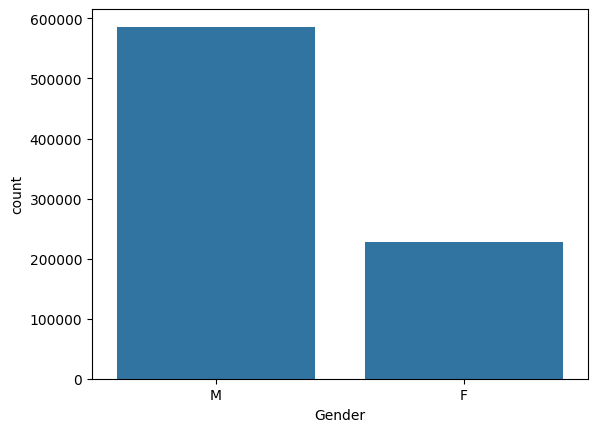

In [26]:
# Use countplot to directly plot the count of occurrences in 'Gender'
sns.countplot(x='Gender', data=df)
plt.show()

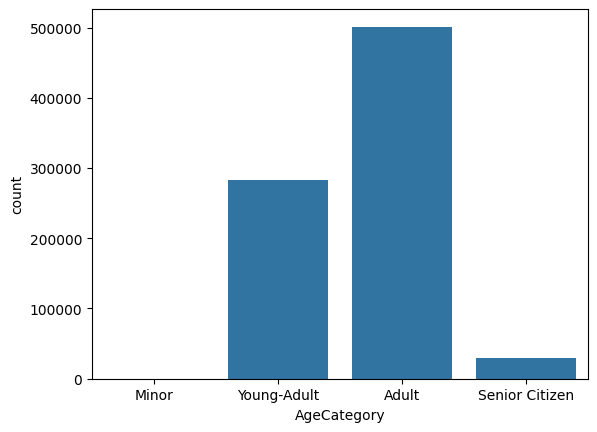

In [27]:
# Use countplot to directly plot the count of occurrences in 'AgeCategory'
sns.countplot(x='AgeCategory', data=df)
plt.show()

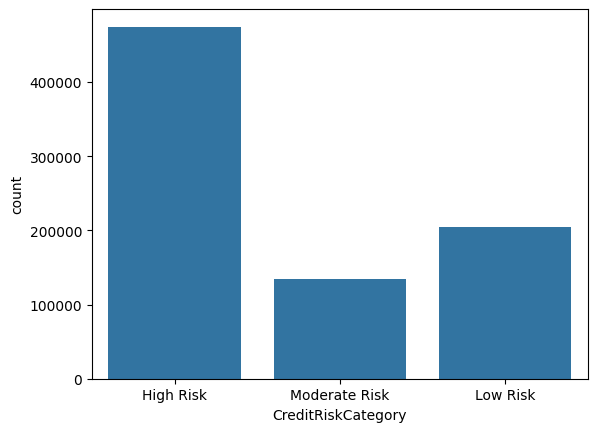

In [28]:
# Use countplot to directly plot the count of occurrences in 'CreditRiskCategory'
sns.countplot(x='CreditRiskCategory', data=df)
plt.show()

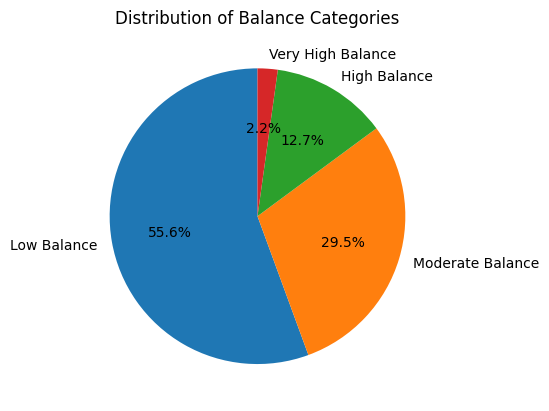

In [29]:
# Calculate value counts for the 'BalanceCategory'
balance_category_counts = df['BalanceCategory'].value_counts()

# Plot a pie chart
plt.pie(balance_category_counts, labels=balance_category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Balance Categories')
plt.show()

In [30]:
#drop customer_id
df.drop(['CustomerID'],axis=1,inplace=True)

In [31]:
categorical_features=df.select_dtypes(include=['object','category']).columns
categorical_features

Index(['Gender', 'City', 'AgeCategory', 'CreditRiskCategory',
       'BalanceCategory'],
      dtype='object')

In [32]:
numerical_features=df.select_dtypes(exclude=['object','category']).columns
numerical_features

Index(['AccountBalance', 'HavingFD', 'HavingCC', 'CIBIL_Score', 'HavingLoan',
       'RV', 'DOB', 'Age', 'FinancialProductCount', 'RV_Balance_Ratio'],
      dtype='object')

#convert the categorical column to numerical

In [33]:
#convert the categorical apply label encoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in categorical_features:
  df[col]=le.fit_transform(df[col])
  print(col)

Gender
City
AgeCategory
CreditRiskCategory
BalanceCategory


In [34]:
df.columns

Index(['Gender', 'City', 'AccountBalance', 'HavingFD', 'HavingCC',
       'CIBIL_Score', 'HavingLoan', 'RV', 'DOB', 'Age', 'AgeCategory',
       'CreditRiskCategory', 'BalanceCategory', 'FinancialProductCount',
       'RV_Balance_Ratio'],
      dtype='object')

#scaling numerical columns

In [35]:
#  Scaling numeric columns
scaler = StandardScaler()
numeric_columns = ['AccountBalance','Age','RV_Balance_Ratio' , 'CIBIL_Score', 'RV']  # Numeric features to scale
df[numeric_columns]= scaler.fit_transform(df[numeric_columns])

In [36]:
df.head()

,Gender,City,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV,DOB,Age,AgeCategory,CreditRiskCategory,BalanceCategory,FinancialProductCount,RV_Balance_Ratio
0,1,0,-0.098641,0,0,1.012701,0,-0.178313,1990-04-01,-0.576300,3,1,2,0,-0.093993
1,1,0,-0.098641,1,0,0.955011,0,-0.126923,1990-04-01,-0.576300,3,1,2,1,-0.093832
2,0,1,-0.126546,0,0,-1.306444,0,-0.140233,1994-05-13,-1.034835,3,0,1,0,-0.090246
3,0,1,-0.126546,0,0,0.441568,0,-0.237506,1994-05-13,-1.034835,3,2,1,0,-0.094092
4,0,1,-0.128947,0,0,-0.498782,0,-0.060763,1991-12-04,-0.690934,3,0,1,0,3.422090


#correlation features

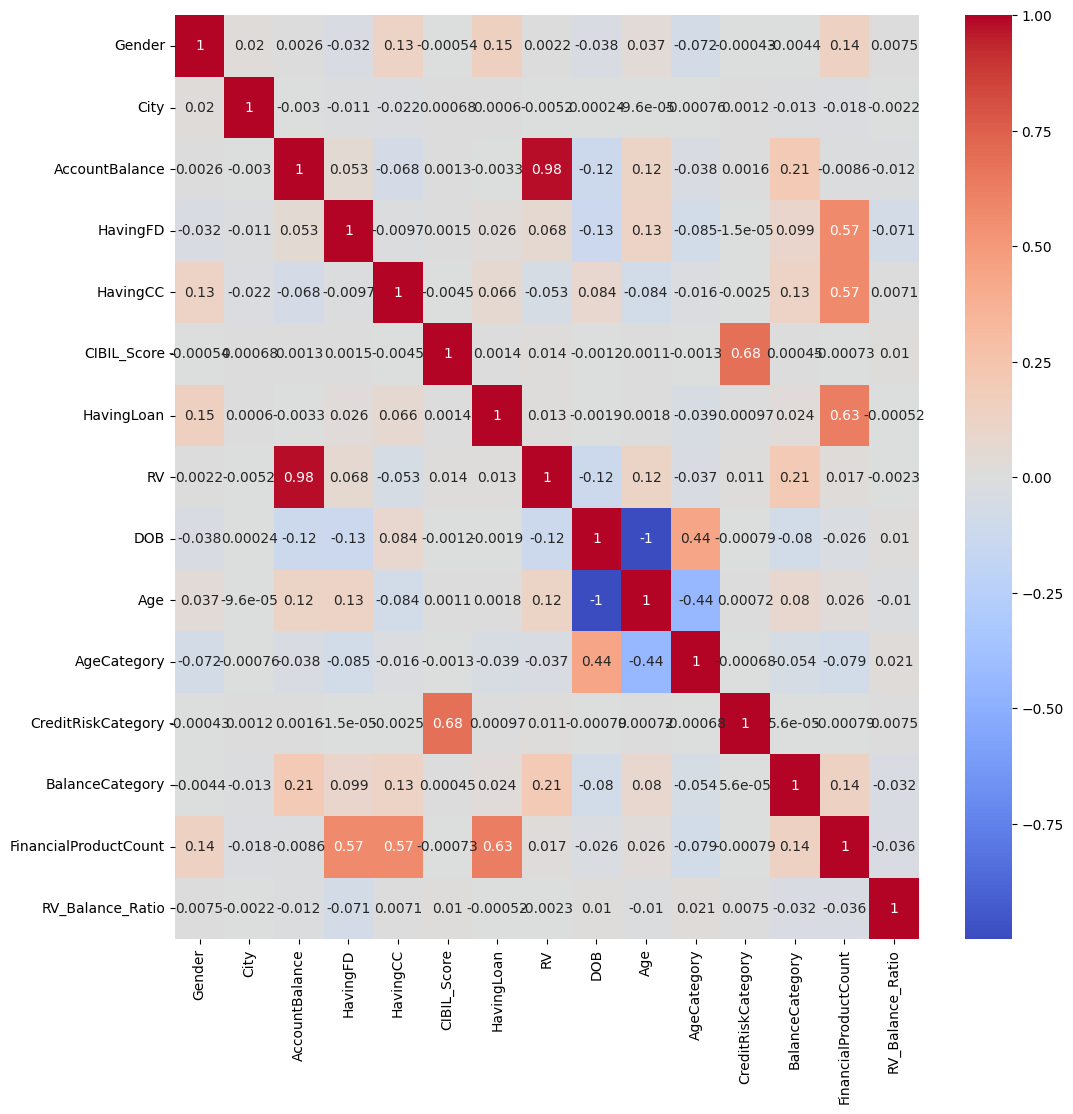

In [37]:
#correlation
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')
plt.show()

#Apply K-mean clustering for unsupervised dataset

In [38]:
#Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Here, K = 3 clusters
df['Cluster'] = kmeans.fit_predict(df[numeric_columns])

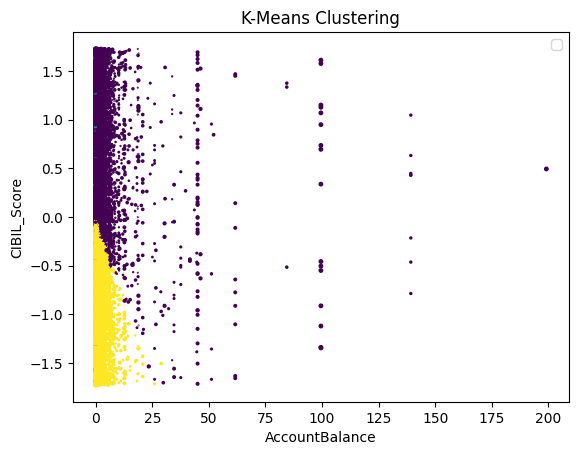

In [40]:
# Visualize the clusters (using two features for simplicity)
plt.scatter(df['AccountBalance'], df['CIBIL_Score'],df['Age'], c=df['Cluster'], cmap='viridis')
plt.xlabel('AccountBalance')
plt.ylabel('CIBIL_Score')
plt.title('K-Means Clustering')
plt.legend()
plt.show()

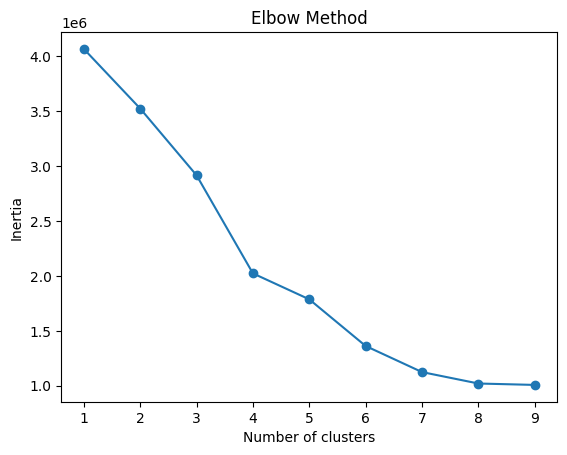

In [41]:
# Using Elbow Method to find the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[numeric_columns])
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [43]:
# Churn if AccountBalance is low and RV is low
df['Churn'] = ((df['AccountBalance'] < -0.1) & (df['RV'] < -0.1)).astype(int)

In [47]:
df.head()

,Gender,City,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV,DOB,Age,AgeCategory,CreditRiskCategory,BalanceCategory,FinancialProductCount,RV_Balance_Ratio,Cluster,Churn
0,1,0,-0.098641,0,0,1.012701,0,-0.178313,1990-04-01,-0.576300,3,1,2,0,-0.093993,0,0
1,1,0,-0.098641,1,0,0.955011,0,-0.126923,1990-04-01,-0.576300,3,1,2,1,-0.093832,0,0
2,0,1,-0.126546,0,0,-1.306444,0,-0.140233,1994-05-13,-1.034835,3,0,1,0,-0.090246,2,1
3,0,1,-0.126546,0,0,0.441568,0,-0.237506,1994-05-13,-1.034835,3,2,1,0,-0.094092,0,1
4,0,1,-0.128947,0,0,-0.498782,0,-0.060763,1991-12-04,-0.690934,3,0,1,0,3.422090,2,0


In [46]:
# Feature columns (excluding the target 'Churn')
X = df.drop(columns=['Churn', 'DOB'])  # Remove target and non-numeric columns like 'DOB'
y = df['Churn']

#spliting dataset in train and test

In [48]:
# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [52]:
# Predict on the test set
y_pred = model.predict(X_test)

In [55]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Accuracy: 0.7532960852648855
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82    107244
           1       0.65      0.61      0.63     55449

    accuracy                           0.75    162693
   macro avg       0.73      0.72      0.72    162693
weighted avg       0.75      0.75      0.75    162693



#save the model

In [56]:
import pickle
pickle.dump(model,open('model.pkl','wb'))